In [1]:
!pip install sqlalchemy

In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd

In [4]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [5]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
from sqlalchemy import and_, or_
from scipy.stats import ttest_ind

In [6]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [7]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [8]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [11]:
first_row = session.query(Measurement).first()
second_row = session.query(Station).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x1186d1650>,
 'tobs': 65.0,
 'date': '2010-01-01',
 'station': 'USC00519397',
 'prcp': 0.08,
 'id': 1}

In [12]:
second_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x1186ec250>,
 'latitude': 21.2716,
 'station': 'USC00519397',
 'elevation': 3.0,
 'longitude': -157.8168,
 'name': 'WAIKIKI 717.2, HI US',
 'id': 1}

# Exploratory Climate Analysis

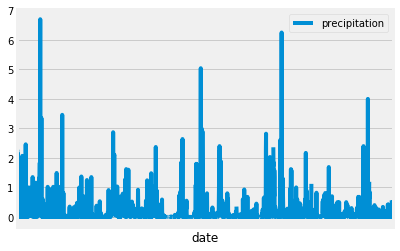

In [13]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
select = [Measurement.date, Measurement.prcp]
# Calculate the date 1 year ago from the last data point in the database
target_date = session.query(select[0]).order_by((func.strftime("%Y-%m-%d", Measurement.date).desc())).first()
target_date_new = target_date[0]
target_date = target_date_new[:3] + str(eval(target_date_new[3])-1) + target_date_new[4:]
# Perform a query to retrieve the data and precipitation scores
# Sort the dataframe by date
date_prec = session.query(select[0],select[1]).filter(func.strftime("%Y-%m-%d", Measurement.date) > target_date)\
                                                .order_by(func.strftime("%Y-%m-%d", Measurement.date)).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
df_date_prec = pd.DataFrame(date_prec, columns = ['date', 'precipitation'])
# Use Pandas Plotting with Matplotlib to plot the data
df_date_prec.plot()
plt.xticks([])
plt.xlabel('date')
plt.show()

In [14]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df_date_prec['precipitation'].describe()

count    2015.000000
mean        0.176462
std         0.460288
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: precipitation, dtype: float64

In [15]:
# Design a query to show how many stations are available in this dataset?
total_station = session.query(func.count(Station.id)).all()
total_station

[(9)]

In [16]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
select = [Measurement.station, func.count(Measurement.station)]
active_station = session.query(*select).group_by(Measurement.station)\
                .order_by(select[1].desc()).all()
active_station

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [17]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
select = [func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)]
temp_station = session.query(*select).filter(Measurement.station == active_station[0][0]).all()
temp_station

[(54.0, 85.0, 71.66378066378067)]

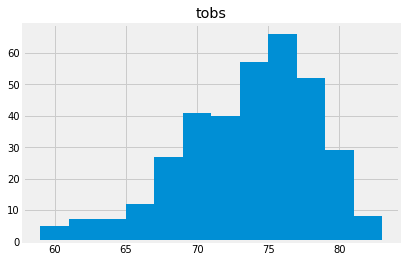

In [18]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
highest_stat = session.query(Measurement.tobs).filter(and_(func.strftime("%Y-%m-%d", Measurement.date) > target_date, 
                                                           Measurement.station == active_station[0][0])).all()
pd_highest_stat = pd.DataFrame(highest_stat, columns = ['tobs'])
pd_highest_stat.hist(bins = 12, label = 'tobs')
# plt.title('')
# plt.legend('tobs', prop = {'size': 13})
plt.show()

In [19]:
# I assume it is a unpaired t-test, because it is not the same sample
june_temp = session.query(Measurement.tobs).filter(func.strftime("%m", Measurement.date) == '06').all()
dec_temp = session.query(Measurement.tobs).filter(func.strftime("%m", Measurement.date) == '12').all()
ttest_ind(june_temp, dec_temp, equal_var = False)

Ttest_indResult(statistic=array([31.35503692]), pvalue=array([4.19352984e-187]))

In [20]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [21]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip_temp = calc_temps('2017-01-01', '2018-01-01')
trip_temp

[(58.0, 74.14387974230493, 87.0)]

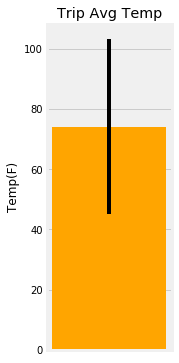

In [22]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
plt.figure(figsize = (2,6))
plt.bar('Trip Avg Temp', trip_temp[0][1], width = 0.1, yerr = (trip_temp[0][2] - trip_temp[0][0]), color = 'orange')
plt.ylabel('Temp(F)')
plt.xticks([])
plt.title('Trip Avg Temp')
plt.show()

In [37]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
rainfall = session.query(Measurement.station, Station.name, Station.latitude, Station.longitude,
                         Station.elevation, Measurement.prcp).filter(Measurement.date == '2012-01-01').filter(Measurement.station == Station.station).group_by(Measurement.station).order_by(Measurement.prcp.desc()).all()
rainfall

[('USC00519281',
  'WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9,
  0.05),
 ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.01),
 ('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  0.01),
 ('USC00511918',
  'HONOLULU OBSERVATORY 702.2, HI US',
  21.3152,
  -157.9992,
  0.9,
  0.0),
 ('USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  7.0,
  0.0),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.0),
 ('USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5,
  0.0)]

## Optional Challenge Assignment

In [24]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [25]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
day = ('01-01', '01-02', '01-03', '01-04', '01-05', '01-06', '01-07')
normals = [daily_normals(i) for i in day]
normals = [i[0] for i in normals]
normals
# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


[(62.0, 69.15384615384616, 77.0),
 (60.0, 69.39622641509433, 77.0),
 (62.0, 68.9090909090909, 77.0),
 (58.0, 70.0, 76.0),
 (56.0, 67.96428571428571, 76.0),
 (61.0, 68.96491228070175, 76.0),
 (57.0, 68.54385964912281, 76.0)]

In [26]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
df_date = pd.DataFrame(normals, columns = ['tmin', 'tavg', 'tmax'], index = day)
df_date

,tmin,tavg,tmax
01-01,62.0,69.153846,77.0
01-02,60.0,69.396226,77.0
01-03,62.0,68.909091,77.0
01-04,58.0,70.000000,76.0
01-05,56.0,67.964286,76.0
01-06,61.0,68.964912,76.0
01-07,57.0,68.543860,76.0


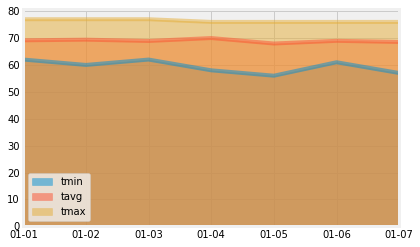

In [27]:
# Plot the daily normals as an area plot with `stacked=False`
df_date.plot.area(stacked = False)
plt.show()